# Gaussian diagonal covariance

Here we figure out the Gaussian diagonal covariance and try to code this ourselves.
Look at
- Gaussian covariance for the $C_{l}$'s; (Dodelson, example 12.1; section 14.2)
- Different noise types
- Expressions for the different types of probes
- Wick's theorem

*Guess:*
1. Gaussian diagonal covariance describes an striclty auto-correlated parameter space. This is expressed in a diagonal covariance matrix, in which the variance in each parameter is Gaussian. The fact that the covariance matrix is diagonal means that any cross-correlations are disregarded. Thus, the parameters panning parameter space are *univariant* in auto-correlations and invariant in cross-correlations.

Look at sources:
- **[Section 2.5: Johnston, H., Chisari, N. E., Joudaki, S., Reischke, R., Stölzner, B., Loureiro, A., ... & Zhang, Y. H. (2024). 6x2pt: Forecasting gains from joint weak lensing and galaxy clustering analyses with spectroscopic-photometric galaxy cross-correlations. arXiv preprint arXiv:2409.17377](https://arxiv.org/abs/2409.17377)**
- **[Later chapters of: Modern Cosmology; S. Dodelson, F. Schmidt](https://books.google.se/books?hl=nl&lr=&id=TpUmEQAAQBAJ&oi=fnd&pg=PP1&dq=modern+cosmology+dodelson&ots=BBo0fsLhcW&sig=KC-2ksaqhpjJvRv05wjpd2nS8Lg&redir_esc=y#v=onepage&q=modern%20cosmology%20dodelson&f=false)**


In [130]:
# The required imports:

import numpy as np
import pyccl as ccl
import pylab as plt
import math
import glass.observations
%matplotlib inline

## Analytical expression:
We can write down the analytical expression for the Gaussian covariance through:
$Z = Cov\left[\hat{C}^{ij}(\ell)\hat{C}^{mn}(\ell')\right]$, with:
$$Cov\left[\hat{C}^{ij}(\ell)\hat{C}^{mn}(\ell')\right] = \frac{\delta_{\ell\ell'}^{K}}{f_{sky} (2\ell + 1)}\left(\hat{C}^{im}(\ell)\hat{C}^{jn}(\ell') + \hat{C}^{in}(\ell)\hat{C}^{jm}(\ell')\right)$$

where $4\pi f_{sky} = A_{survey}$ the fraction of the sky considered in the survey, $\delta_{\ell\ell'}^{K}$ is the K-dimensional Dirac delta which ensures that the multipole moments ($\ell$) are independent. In this expression we must note that $\hat{C}^{ij}(\ell)$ is the observed angular power spectrum. This means that it contains both the signal $\left(S^{ij}(\ell)\right)$ and the noise $\left(N^{ij}\right)$:
$$\hat{C}^{ij}(\ell) = S^{ij}(\ell) + N^{ij}\delta_{ij} $$

More specifically,
$$
\hat{C}^{ij} (\ell) = \begin{cases}
S^{ij} (\ell) + N_{source}^{ij}\delta_{ij}, & \text{if $i \wedge j \in$ source}.\\
S^{ij} (\ell) + N_{lens}^{ij}\delta_{ij}, & \text{if $i \wedge j \in$ lens}.\\
S^{ij} (\ell), & \text{else}
\end{cases}
$$

Where the noise differs for the case of galaxy clustering, weak lensing or CMB lensing. Note also that the noise only occurs for the auto-correlations (e.g. the diagonal of the covariance). 

Note: For CMB lensing, we make use of the noise as defined by Planck, stowed away in the file 'cmb_noise_Planck.txt' which we read in and use when needed.

In [154]:
# Start with a simple case of the diagonal gaussian covariance:

# We look at the auto correlation of a single variation of the angularpower spectrum
def simple_Gaussian_cov(l, IM, JN, IN, JM, f_sky, noise=None):
    
    # # Set the noise to 0 if there is no noise specified:
    # if noise == None:
    #     noise = np.zeros_like(l)
    
    # Initiate the covariance matrix:
    simple_cov = np.zeros(shape=(len(l), len(l)))
    
    # Now we calculate the covariance of the elements:
    for i in range(len(l)):
        pref = 1/(f_sky * (2*l[i] + 1))
        for j in range(len(l)):
            if i == j:
                simple_cov[i, j] = pref * ((IM[i] * JN[j]) + (IN[i] * JM[j]) + (noise[j] * noise[j]) + ((IM[i] + IN[i]) * noise[j]) + ((JN[j] + JM[j]) * noise[i]))
            else:
                simple_cov[i, j] = pref * ((IM[i] * JN[j]) + (IN[i] * JM[j]))

    return simple_cov


A (7, 7) matrix, which contains the following:
 [[39.68253968 32.53968254 22.22222222 42.46031746 35.31746032 28.57142857
  38.49206349]
 [ 8.1027668   6.64426877  4.53754941  8.66996047  7.21146245  5.83399209
   7.85968379]
 [ 3.16027088  2.59142212  1.76975169  3.38148984  2.81264108  2.27539503
   3.06546275]
 [ 4.22590837  3.46524487  2.36650869  4.52172196  3.76105845  3.04265403
   4.09913112]
 [ 2.70352369  2.21688943  1.51397327  2.89277035  2.40613609  1.94653706
   2.62241798]
 [ 1.7769003   1.45705824  0.99506417  1.90128332  1.58144126  1.27936821
   1.72359329]
 [ 2.01579385  1.65295096  1.12884456  2.15689942  1.79405653  1.45137157
   1.95532003]]


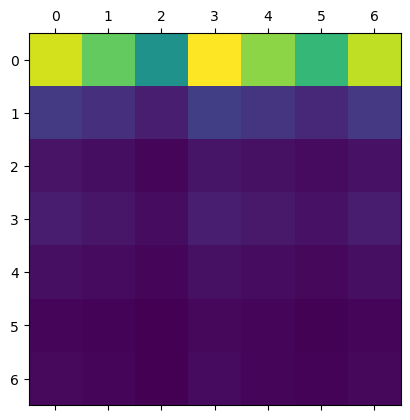

In [152]:
# Now we define a function that gives us the Gaussian coavariance based on the probe, the corresponding noise and surveysurface on the observed sky,
# a redshift distribution, bins and their binwidth.

def Gauss_cov(l, ang_power_spectrum, noise, f_sky, redshift_dist=None, bins=None, cross=False):
    # We calculate the Gaussia covariance based on the true-model tracer. The angular power spectrum that represents LCDM
    cov = np.zeros(shape=(len(ang_power_spectrum), len(ang_power_spectrum)))
    
    # We separate the cases of auto and cross-correlations:
    if cross == False:
        
        # Now we need to take into account the noise acompanying the angular power spectrum
        for i in range(len(l)):
            for j in range(len(l)):

                # For the diagonal elements, we compute auto correlations of the same probes, thus we includer the noise terms. Assume
                if i == j:
                    cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spectrum[i] * ang_power_spectrum[j] + ang_power_spectrum[i] * ang_power_spectrum[j] + noise[i] * ang_power_spectrum[j] + ang_power_spectrum[i] * noise[j] + noise[i] * noise[j])
                
                # For the non-diagonal elements:
                else:
                    cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spectrum[i] * ang_power_spectrum[j] + ang_power_spectrum[i] * ang_power_spectrum[j])
    
    # Now for the cross-correlations:
    else:
        for i in range(len(l)):
            for j in range(len(l)):
                cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spectrum[i] * ang_power_spectrum[j])
    
    return cov

tracer = np.array([100, 82, 56, 107, 89, 72, 97])
noise = np.ones_like(tracer)
l = np.linspace(10, 200, len(tracer))

print("A", Gauss_cov(l, tracer, noise, 12, cross=True).shape, "matrix, which contains the following:\n", Gauss_cov(l, tracer, noise, 12, cross=True))

plt.matshow(Gauss_cov(l, tracer, noise, 2, cross=True), None)
plt.show()

## Generate the angular power spectra
To generate these we first get 

In [133]:
# We define the cosmology:
lcdm_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Alternate neutrino cosmology:
neutrino_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, m_nu=0.12, mass_split='normal')
zero_mm_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, m_nu=[0, 0.06, 0.06])

# The specifics of the angular power spectra:
l = np.linspace(2, 2000, 100) # multipole moments
z = np.linspace(0., 3.0, 100) # redshifts
a = (1./(1+z))[::-1]

# Redshoft distribution:
nz = np.exp(-((z-0.5)/0.05)**2/2)

# Biases:
bias = 0.95/ccl.growth_factor(lcdm_cosmo, a) # bias
m_bias = np.ones_like(z) # Magnification bias
i_a = -0.004 * np.ones_like(z) # Intrinsic alignment amplitude

### Binning:
Define the spectroscopic and photometric bins

30


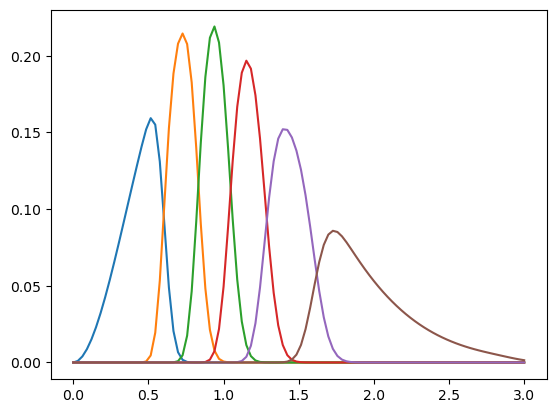

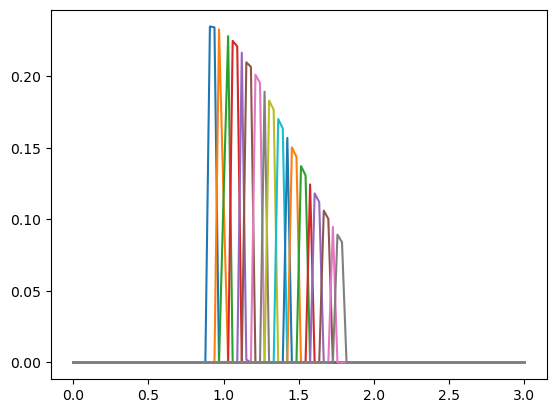

In [134]:
# We define the photometric and spectra through the following:

# Photometric:
n_bar = 0.3 # Assume a galaxy density and accompanying reshift distribution:
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
dndz *= n_bar
zbins = glass.observations.equal_dens_zbins(z, dndz, nbins=6)
phot_tomo_bins = glass.observations.tomo_nz_gausserr(z, dndz, 0.03, zbins) # Where the bin error is 0.03

# Spectroscopic:
spec_z = (np.heaviside((z - 0.9), 1) - np.heaviside((z - 1.8), 1)) * dndz
spec_zbins = glass.observations.fixed_zbins(zmin=0.9, zmax=1.8, dz=0.05)
spec_tomo_bins = glass.observations.tomo_nz_gausserr(z, spec_z, 0.0003, spec_zbins)
print(np.sum(spec_z>0))

# Show the photometric bins in a plot:
plt.figure()
for i in range(len(phot_tomo_bins)):
    plt.plot(z, phot_tomo_bins[i])
plt.show()

# Show the spectroscopic bins in a plot:
plt.figure()
for i in range(len(spec_tomo_bins)):
    plt.plot(z, spec_tomo_bins[i])
plt.show()

### Defining the tracers:
Here we define the tracers we are interested in and which we want to use to define the 

In [135]:
# Define an empty dictionary for the tracers:
tracers = {}

# Define the tracers:
photo_clus = {i: ccl.NumberCountsTracer(lcdm_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
spec_clus = {i: ccl.NumberCountsTracer(lcdm_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
wl = {i: ccl.WeakLensingTracer(lcdm_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
cmb_l = ccl.CMBLensingTracer(lcdm_cosmo, z_source=1100., n_samples=5500)

print(wl[0])

<pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0xa69c5805a95a9900         None           2       -1   


### Angular power spectra of interest
With the tracers we defined above, we can nof set up the angular power spectra we are interested in. Look at the auto and cross corrlations of the CMB lensing tracer. These effectively are the correlations that extend the 6x2pt. analysis to the 10x2pt analysis:
- $\kappa$ x $\kappa $
- $\kappa$ x $\gamma^{\epsilon}$
- $\kappa$ x $\delta_{g}^{p}$
- $\kappa$ x $\delta_{g}^{s}$

In [149]:
# Define the auto and cross correlations of the CMB lensing tracer within the 6xapt framework:
auto_cmb = ccl.angular_cl(lcdm_cosmo, cmb_l, cmb_l, l, l_limber=1120)
cmb_wl = {i: ccl.angular_cl(lcdm_cosmo, cmb_l, wl[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
cmb_gc_ph = {i: ccl.angular_cl(lcdm_cosmo, cmb_l, photo_clus[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
cmb_gc_sp = {i: ccl.angular_cl(lcdm_cosmo, spec_clus[i], cmb_l, l, l_limber=1120) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the auto-correlations of the tracers:
auto_gc_ph = {i: ccl.angular_cl(lcdm_cosmo, photo_clus[i], photo_clus[i], l) for i in range(len(phot_tomo_bins))}
auto_gc_sp = {i: ccl.angular_cl(lcdm_cosmo, spec_clus[i], spec_clus[i], l) for i in range(len(spec_tomo_bins))}
auto_wl = {i: ccl.angular_cl(lcdm_cosmo, wl[i], wl[i], l) for i in range(len(phot_tomo_bins))}

# The noise types accompanying the angular power spectra:
# Poisson error for galaxy clustering noise, point sources tracing homogeneous background field:
noise_gc = 1/n_bar * np.ones_like(auto_gc_ph[0])

# Combined Poisson and Gaussian error for the point source distributions and Gaussian shear of galaxy shapes:
sigma_e = 0.28 # sigma_e_squared
noise_wl = sigma_e/n_bar * np.ones_like(auto_wl[0])

# For the CMB lensing noise we reference the method of Planck, resulting in:
noise_cmb_l = np.loadtxt('/home/xander/Masters-Project/notebooks/cmb_noise_Planck.txt')[:, 1]

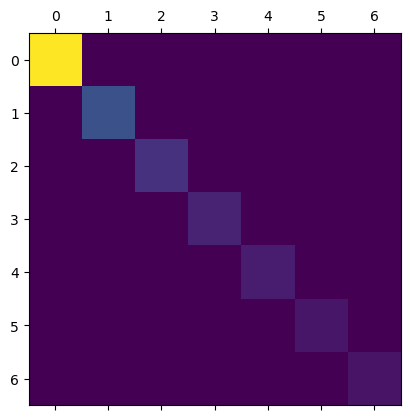

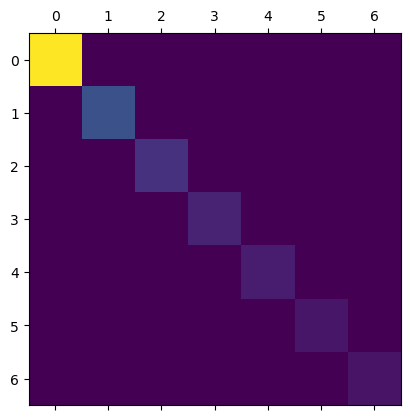

In [ ]:
# Now we want to determine the Gaussian covariance:
cov_cmbl_wl = simple_Gaussian_cov(l, cmb_wl[0], cmb_wl[0], auto_cmb, auto_wl[0], 0.12, noise=noise_wl)
cov_cmbl_wl_next = simple_Gaussian_cov(l, cmb_wl[5], cmb_wl[5], auto_cmb, auto_wl[5], 0.12, noise=noise_wl)

plt.matshow(cov_cmbl_wl)
plt.matshow(cov_cmbl_wl_next)
plt.show()